# SLA Investigation
1. Run all cells! (click on Menu > Cell > Run All Cells)
1. View report at the bottom.

In [1]:
triggerTime='2019-07-29 16:00:37.0Z'
scaleUnit=''
service='tfs'

In [2]:
%%capture 

# install packages, setup workspace root
!pip install --upgrade pip azure-kusto-notebooks
import os
import sys
import datetime
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
pd.options.display.html.table_schema = True
import concurrent.futures
from azure.kusto.notebooks import utils as akn

# cwd should be workspace root
if os.path.basename(os.getcwd()) == 'devops-pipelines':
    os.chdir(os.pardir)

In [3]:
# authenticate kusto client
# you will need to copy the token into a browser window for AAD auth. 
client = akn.get_client('https://vso.kusto.windows.net')

To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code FUR9KAQCQ to authenticate.


In [23]:
# find orchestrations that violate SLA
params = {
    'TriggerTime': akn.to_kusto_datetime(triggerTime),
    'Service': '"' + service + '"', 
    'ScaleUnit': '"' + scaleUnit + '"'
}
query = os.path.join('devops-pipelines', 'queries', 'sla', 'SLADurationAnalysis.csl')
violations = akn.execute_file(client, database='VSO', path=query, params=params)
# violations

In [24]:
# collect problematic orchestration ids
result = violations.primary_results[0]
oid_column_index = next((c.ordinal for c in result.columns if c.column_name == 'OrchestrationId'), None)
su_column_index = next((c.ordinal for c in result.columns if c.column_name == 'ScaleUnit'), None)

# group
by_su = {}
for r in result.rows:
    su = r[su_column_index]
    oid = r[oid_column_index]
    l = by_su.get(su, [])
    by_su[su] = l
    l.append(oid)

max_scale_units = []
max_problems = 0
for k,v in by_su.items():
  c = len(v)
  if c > max_problems:
    max_problems = c
    max_scale_units = [k]
  elif c == max_problems:
    max_scale_units.append(k)
max_scale_units.sort()

# for su, oids in by_su.items():
#     print(su)
#     for oid in oids:
#         print('   ', oid)

In [31]:
# collect visualization data sets
query = os.path.join('devops-pipelines', 'queries', 'sla', 'SLAVisualization.csl')
with concurrent.futures.ThreadPoolExecutor() as executor:
    hfs = [executor.submit(akn.execute_file, client, 'VSO', query, 
            {
                'ScaleUnit': '"' + r[su_column_index] + '"', 
                'OrchestrationId': '"' + r[oid_column_index] + '"'
            }) for r in result.rows]
    histories = [h.result() for h in concurrent.futures.as_completed(hfs)]

# convert to data frames
primary_results = [h.primary_results[0] for h in histories]
dataframes = None
with concurrent.futures.ThreadPoolExecutor() as executor:
    dataframe_futures = [executor.submit(akn.to_dataframe, r) for r in primary_results]
    dataframes = [dff.result() for dff in concurrent.futures.as_completed(dataframe_futures)]
histories = None

# try to filter out false positives? at least 
required_phases = ('RunAgentJob.SendJob', 'RunAgentJob.JobCompleted')
dataframes = [df for df in dataframes if all([p in df['PhaseName'].values for p in required_phases])]

# final
number_of_violations = len(dataframes)

In [32]:
# what was the worst phase?
if dataframes:
    combined = pd.concat(dataframes, ignore_index=True)
    worst_df = combined.loc[combined['Level'] == 2].groupby(['PhaseName']).size().to_frame('Count').nlargest(1, 'Count')
    worst_phaseName = worst_df.index[0]
    worst_count = worst_df.iat[0, 0]
    worst_team = worst_phaseName.split('.')[0]

In [33]:
if number_of_violations <= 0:
    print('INSIGHT: no problems detected')
else:
    print('INSIGHT! There are', number_of_violations, 'plans out of SLA.')
    print('INSIGHT: the most problems (' + str(max_problems) + ')', 'are in', ', '.join(max_scale_units))
    print('INSIGHT: There might be a problem with', worst_phaseName + '.', 
          'It was the slowest in', worst_count, 'of the', number_of_violations, 'SLA violations.')
    print('ACTION: open icm against scale units:', max_scale_units, ', assign it to:', worst_team)

INSIGHT! There are 2 plans out of SLA.
INSIGHT: the most problems (8) are in su3
INSIGHT: There might be a problem with RunAgentJob.SendJob. It was the slowest in 2 of the 2 SLA violations.
ACTION: open icm against scale units: ['su3'] , assign it to: RunAgentJob


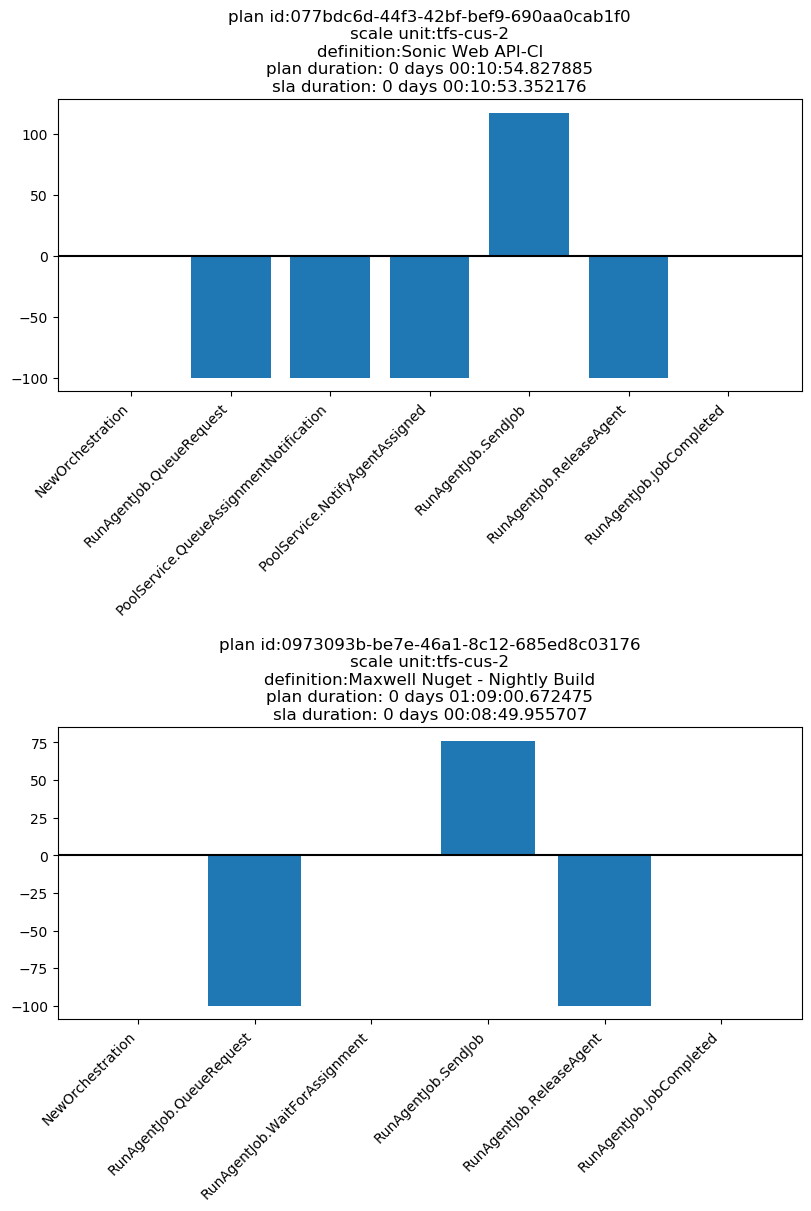

In [34]:
# view all histories
%matplotlib inline

plt.rcdefaults()
fig, axes = plt.subplots(nrows=number_of_violations, 
                         ncols=1, 
                         figsize=(8, 6 * number_of_violations),
                         constrained_layout=True)

vdf = akn.to_dataframe(violations.primary_results[0])
for i in range(number_of_violations):
    df = dataframes[i]
    ax = axes[i] if number_of_violations > 1 else axes
    ax.axhline(0, color='k')
    
    x = df['PhaseName']
    xpos = np.arange(len(x))
    y = df['PercentDifference']
    plan_id = df['PlanId'].iloc[0]
    
    violation_row = vdf.loc[vdf['PlanId'] == plan_id]
    title = '\n'.join([
        'plan id:' + plan_id,
        'scale unit:'     + str(violation_row['ScaleUnit'].iloc[0]),
        'definition:'     + str(df['DefinitionName'].iloc[0]),
        'plan duration: ' + str(violation_row['PlanDuration'].iloc[0]),
        'sla duration: '  + str(violation_row['TotalSLADuration'].iloc[0]),
    ])
    ax.title.set_text(title)
    
    ax.bar(x=xpos, height=y)
    ax.set_xticks(xpos)
    ax.set_xticklabels(x, rotation=45, ha="right")

# output_filename = 'analysis.svg'
# plt.savefig(output_filename, format='svg')